<a href="https://colab.research.google.com/github/savibatuan/PHYS486-S22/blob/main/FinalProject/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

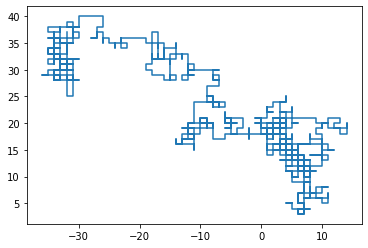

In [4]:
#Generic Random Walk without defect(2D)

import numpy as np
import matplotlib.pyplot as plt
import random

#the number of steps the simulation is going to move
step = 1000 
#the allowed grid size on which the simulation will be performed(i.e grid= 10 will produce 10x10 matrix)
grid = 10

#Create the arrays to store positions in x and y direction
#Starting movement from the midpoint
if grid % 2 == 0: #checks if given grid is divisible by 2 to find midpoint
  midpoint = grid/2
else:
    midpoint = (grid-1)/2 #if not divisable by 2, then subtract one and then find midpoint
x = np.full((step) , midpoint)
y = np.full((step), midpoint)

#Creating the directions the simulation can move in
direction=["Up", "Down", "Left", "Right"]

#Creating a matrix from the given grid size, within which the simulation is allowed to move
def matrix(grid):
  rows = grid
  cols = grid
  return rows, cols
  
rows, cols = matrix(grid)
for i in range(1,step):
  move = random.choice(direction)
  if move == "Up":
    if y[i] == rows : #if the simulation position is at the top of the allowed matrix the move will be disregarded
      x[i] = x[i-1]
      y[i] = y[i-1]
    else:
      x[i] = x[i-1]
      y[i] = y[i-1] + 1 #otherwise it will move one position up

  elif move == "Down":
    if y[i] == 0:
      x[i] = x[i-1]
      y[i] = y[i-1]
    else:
      x[i] = x[i-1]
      y[i] = y[i-1] -1


  elif move == "Left":
    if x[i] == 0:
      x[i] = x[i-1]
      y[i] = y[i-1]
    else:    
      x[i] = x[i-1] -1
      y[i] = y[i-1]


  elif move == "Right":
    if x[i] == cols:
      x[i] = x[i-1]
      y[i] = y[i-1]
    else:
      x[i] = x[i-1] +1
      y[i] = y[i-1]

plt.plot(x,y)
plt.show()


In [ ]:
#Generic Random Walk with defect(2D)
density = .1 #The density of defects within a given grid

#Determines the numbers of defects in the given grid
num_defects = int(density * rows * cols)

#Creating an empty matrix to be able to place 
def create_grid(rows, cols):
  defect_position = np.empty((rows, cols))
  return defect_position


#Randomly populate the grid with defects
for i in range (num_defects):
  defect_position = create_grid(rows, cols)
  position = np.random(0, rows*cols)
  defect_position[position, :] = 0
  defect_position[:, position] = 0




TypeError: ignored

In [ ]:
#Max Entropy Random Walk with defect